In [663]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from GB_ZO.algorithms import *

In [664]:
#Note: D=99 => very slow with multi, fast with SPSA
class MLPPolicy:
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=0.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.epsilon = epsilon  # exploration rate

        # Initialize weights
        self.W1 = np.random.randn(hidden_dim, input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(output_dim, hidden_dim)
        self.b2 = np.zeros(output_dim)

    def act(self, obs):
        if np.random.rand() < self.epsilon:
            # Random action with prob epsilon
            return np.random.choice(self.output_dim)
        z1 = np.tanh(self.W1 @ obs + self.b1)
        out = self.W2 @ z1 + self.b2
        return int(np.argmax(out))

    def get_params(self):
        return np.concatenate([self.W1.flatten(), self.b1, self.W2.flatten(), self.b2])

    def set_params(self, params):
        offset = 0
        W1_size = self.hidden_dim * self.input_dim
        self.W1 = params[offset:offset+W1_size].reshape(self.hidden_dim, self.input_dim)
        offset += W1_size

        self.b1 = params[offset:offset+self.hidden_dim]
        offset += self.hidden_dim

        W2_size = self.output_dim * self.hidden_dim
        self.W2 = params[offset:offset+W2_size].reshape(self.output_dim, self.hidden_dim)
        offset += W2_size

        self.b2 = params[offset:offset+self.output_dim]

In [665]:
def evaluate_policy(env, policy, n_episodes=5):
    total_reward = 0.0
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = policy.act(obs)
            obs, _, terminated, truncated, _ = env.step(action)
            position = obs[0]
            velocity = obs[1]

            shaped_reward = (
                    100 * (position >= env.unwrapped.goal_position) +
                    5 * abs(velocity) +
                    np.sin(3 * position) -
                    1
            )

            total_reward += shaped_reward
            done = terminated or truncated

    return total_reward / n_episodes

In [666]:
def train(env_name, gradient_fn, steps=100, alpha_init=0.5, K_init=0.05, hidden_dim=16, momentum=0):
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy = MLPPolicy(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, epsilon=0)

    best_params = policy.get_params()
    best_reward = -np.inf
    history = []

    v = np.zeros_like(best_params)

    for step in tqdm(range(steps)):
        alpha = alpha_init / (1 + 0.01 * step)
        K = K_init / (1 + 0.01 * step)

        def loss_fn(params):
            policy.set_params(params)
            return -evaluate_policy(env, policy)

        x = policy.get_params()
        grad = gradient_fn(x, loss_fn, K)
        grad = np.clip(grad, -1.0, 1.0)

        # Standard momentum update
        v = momentum * v + grad
        new_params = x - alpha * v
        policy.set_params(new_params)

        current_reward = -loss_fn(new_params)
        history.append(current_reward)

        if current_reward > best_reward:
            print(f"Step {step} - New best reward: {current_reward:.2f}")
            best_reward = current_reward
            best_params = new_params.copy()
        else:
            policy.set_params(best_params)

    env.close()
    return history, best_params


In [667]:
def visualize_policy(env_name, params, hidden_dim=16):
    env = gym.make(env_name, render_mode="human")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy = MLPPolicy(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, epsilon=0)
    policy.set_params(params)

    obs, _ = env.reset()
    done = False
    while not done:
        action = policy.act(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.render()
    env.close()

In [668]:
#np.random.seed(42)

print("Training with SPSA...")
spsa_history, spsa_best = train("MountainCar-v0", spsa_gradient)
print("Training with Multipoint...")
multi_history, multi_best = train("MountainCar-v0", multipoint_gradient_estimator)

Training with SPSA...


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

Step 0 - New best reward: -397.14


  2%|▏         | 2/100 [00:00<00:17,  5.65it/s]

Step 1 - New best reward: -392.33


  7%|▋         | 7/100 [00:01<00:15,  6.11it/s]

Step 5 - New best reward: -391.24


 88%|████████▊ | 88/100 [00:13<00:01,  6.37it/s]

Step 86 - New best reward: -391.08


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Training with Multipoint...


  1%|          | 1/100 [00:10<16:42, 10.13s/it]

Step 0 - New best reward: -360.98


  2%|▏         | 2/100 [00:20<16:26, 10.07s/it]

Step 1 - New best reward: -359.63


  3%|▎         | 3/100 [00:30<16:12, 10.02s/it]

Step 2 - New best reward: -359.62


  4%|▍         | 4/100 [00:40<15:58,  9.99s/it]

Step 3 - New best reward: -350.81


 17%|█▋        | 17/100 [03:16<18:39, 13.49s/it]

Step 16 - New best reward: -349.88


 22%|██▏       | 22/100 [04:16<15:03, 11.59s/it]

Step 21 - New best reward: -346.32


 28%|██▊       | 28/100 [05:37<15:21, 12.79s/it]

Step 27 - New best reward: -345.91


 86%|████████▌ | 86/100 [15:04<01:24,  6.00s/it]

Step 85 - New best reward: -345.31


100%|██████████| 100/100 [17:26<00:00, 10.46s/it]


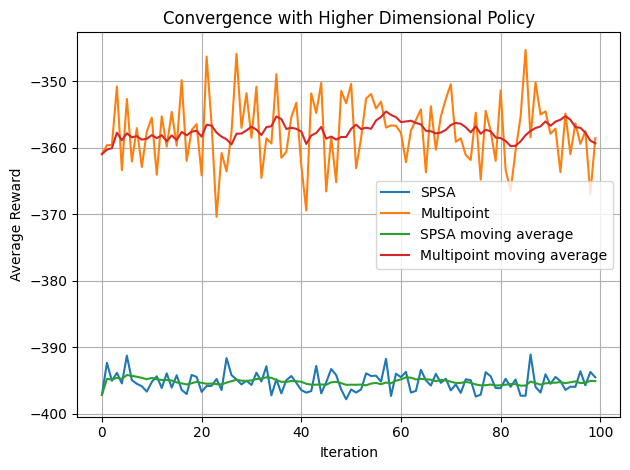

In [669]:
# Plot convergence
plt.plot(spsa_history, label="SPSA")
plt.plot(multi_history, label="Multipoint")

def compute_moving_avg(history, window_size):
    data = np.array(history)
    cumsum = np.cumsum(np.insert(data, 0, 0))  # Insert zero at start for easy indexing
    smoothed = (cumsum[window_size:] - cumsum[:-window_size]) / window_size  # Normal moving average for points >= window_size
    first_points = [np.mean(data[:i+1]) for i in range(window_size-1)]
    return np.concatenate([first_points, smoothed])

spsa_ma = compute_moving_avg(spsa_history, 10)
spsa_multi = compute_moving_avg(multi_history, 10)

plt.plot(spsa_ma, label="SPSA moving average")
plt.plot(spsa_multi, label="Multipoint moving average")

plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.title("Convergence with Higher Dimensional Policy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [671]:
visualize_policy("MountainCar-v0", spsa_best)

Visualizing best SPSA policy...


In [672]:
visualize_policy("MountainCar-v0", multi_best)